# ML Pipeline

## Step 1: Collect data

In [117]:
# Data Processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 
from scipy import stats

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *

from sklearn.linear_model import *
from sklearn.neighbors import *
from sklearn.svm import *
from sklearn.naive_bayes import *
from sklearn.tree import *
from sklearn.ensemble import *
from sklearn.discriminant_analysis import *

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, f1_score
from sklearn.model_selection import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from imblearn.under_sampling import RandomUnderSampler


In [118]:
# read the data
red_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
white_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep=';')

## Step 2: Prepare the data

### Cleaning

Remove unwanted data (duplicates)

In [119]:
# remove lines that have all values duplicated
red_wine.drop_duplicates(inplace=True, ignore_index=True)
white_wine.drop_duplicates(inplace=True, ignore_index=True)

Missing data - luckily there is none, but let's confirm that.

In [120]:
# check for missing data
red_wine.isnull().sum().any()

False

In [121]:
# check for missing data
white_wine.isnull().sum().any()

False

Add quality labels and combine data

In [122]:
# add quality_label column
for wine_df in [red_wine, white_wine]:
    # we are creating a new column called "quality_label", we define a range and associate that range with a label
    wine_df['quality_label'] = wine_df['quality'].apply(lambda value: 'low'
    if value <= 5 else 'medium'
    if value <= 7 else 'high')

    # here we are transforming these labels into categrical data type (specific to pandas) instead of simple string
    wine_df['quality_label'] = pd.Categorical(wine_df['quality_label'],
    categories=['low', 'medium', 'high'])

Remove quality column (we are going to use quality labels only)

In [123]:
# drop quality column
for wine_df in [red_wine, white_wine]:
    wine_df.drop(['quality'], axis=1, inplace=True)

Make a df with both wine types with a column indicating color

In [124]:
# add column with color of wine
red_wine['color'] = 'red'
white_wine['color'] = 'white'

# combine the wine dfs
wine = pd.concat([red_wine, white_wine], ignore_index=True)

# here we are transforming these labels into categrical data type (specific to pandas) instead of simple string
wine['color'] = pd.Categorical(wine['color'],
categories=['red', 'white'])

# drop the color from red and white wind dfs (it's not necessary there)
red_wine.drop(['color'], axis=1, inplace=True)
white_wine.drop(['color'], axis=1, inplace=True)

Adjust feature names

In [125]:
# use the rename method to change all columns names lowercase and add an underscore if they are made of 2 words
for wine_df in [wine, red_wine, white_wine]:
    wine_df.rename(str.lower, axis='columns', inplace=True)  # make the names lowercase
    wine_df.columns = wine_df.columns.str.replace(' ', '_')     # replace space with underscore in column names

### Visualising

Wine quality class distribution. It's very unbalanced.

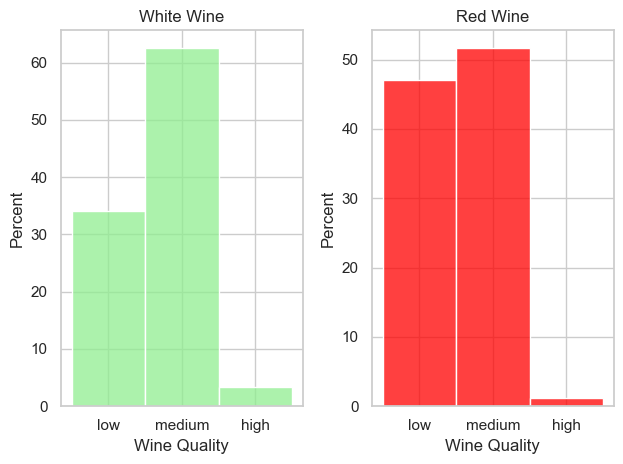

In [126]:
# since the main focus is on quality, let's have a look on how it is distributed.

# set the style of seaborn
sns.set(style="whitegrid")

# create a figure with two side-by-side histograms
fig, axes = plt.subplots(1, 2)

# plot the first histplot on the left (axes[0])
sns.histplot(data=white_wine, x='quality_label', color='lightgreen', stat='percent', ax=axes[0])
axes[0].set_title('White Wine')
axes[0].set_xlabel('Wine Quality')

# plot the second histplot on the right (axes[1])
sns.histplot(data=red_wine, x='quality_label', color='red', stat='percent', ax=axes[1])
axes[1].set_title('Red Wine')
axes[1].set_xlabel('Wine Quality')

# adjust layout is used to adjust the layout so that the plots don't overlap
plt.tight_layout()

# show the plot
plt.show()

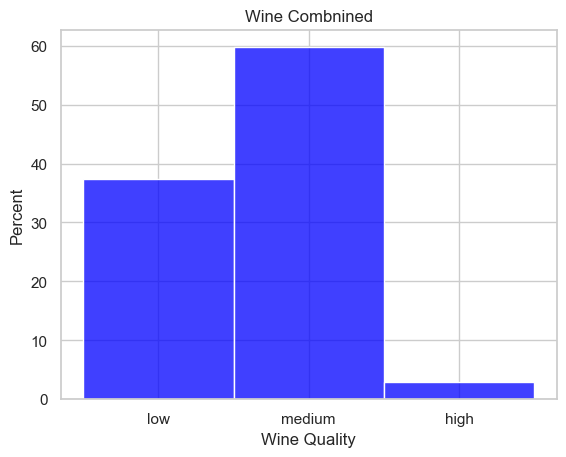

In [127]:
# since the main focus is on quality, let's have a look on how it is distributed.

# set the style of seaborn
sns.set(style="whitegrid")

# plot the first histplot on the left (axes[0])
sns.histplot(data=wine, x='quality_label', color='blue', stat='percent')

plt.title('Wine Combnined')
plt.xlabel('Wine Quality')  # set the x-axis label

# show the plot
plt.show()

Encode the color (for the machine learning they are required to be numerical)

In [128]:
# create an instance of OneHotEncoder
oh_enc = OneHotEncoder(categories=[['red','white']])

# fit and transform the 'color' column
encoded_color = oh_enc.fit_transform(wine[['color']])

# convert the one-hot encoded data to a DataFrame
encoded_color_df = pd.DataFrame(encoded_color.toarray(), columns=oh_enc.get_feature_names_out(['color']))

# concatenate the one-hot encoded DataFrame with 'wine_ml'
wine = pd.concat([wine, encoded_color_df], axis=1)

# drop the original 'color' column from 'wine_ml'
wine = wine.drop('color', axis=1)

Encode the quality labels

In [129]:
# replace the quality labels with numerical values
for wine_df in [wine, red_wine, white_wine]:
    quality_codes = {'low' : 0, 'medium' : 1, 'high' : 2}
    wine_df['quality_label'].replace(quality_codes, inplace=True)

In [130]:
wine

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality_label,color_red,color_white
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0,1.0,0.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,0,1.0,0.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,0,1.0,0.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,1,1.0,0.0
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5315,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,1,0.0,1.0
5316,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,0,0.0,1.0
5317,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,1,0.0,1.0
5318,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,1,0.0,1.0


Split data

In [131]:
X = wine.drop(['quality_label'], axis=1) # features
y = wine['quality_label']  # target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Random Undersampling (to balance the data)

In [132]:
# Apply Random Undersampling
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

# Step 3: Choose a model


The most common algorithms which are used for Multi-Class Classification are :

- K-Nearest Neighbours
- Naive Bayes
- Decision trees
- Gradient Boosting
- Random Forest

In [133]:
rf = RandomForestClassifier()

# Step 4: Train the model

# Step 5: Evaluate the model

In [134]:
def evaluate_model_with_statistics(model, X_train, X_test, y_train, y_test, n=1):

    metrics_list = []

    for _ in range(n):
        # train the model
        model.fit(X_train, y_train)

        # make predictions on the test set
        y_pred = model.predict(X_test)

        # calculate evaluation metrics
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        accuracy = accuracy_score(y_test, y_pred)
        kappa = cohen_kappa_score(y_pred, y_test)

        metrics_list.append({
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'kappa': kappa
        })

    # calculate average and standard deviation
    avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
    std_metrics = {k: np.std([m[k] for m in metrics_list]) for k in metrics_list[0]}

    return {
        'average_metrics': avg_metrics,
        'std_metrics': std_metrics
    }


In [135]:
# baseline
evaluation_results = evaluate_model_with_statistics(rf, X_train, X_test, y_train, y_test, n=10)
pd.DataFrame.from_dict(evaluation_results)

,average_metrics,std_metrics
accuracy,0.719079,0.003158
precision,0.723731,0.004837
recall,0.719079,0.003158
f1,0.709484,0.003080
kappa,0.416663,0.006384


In [136]:
# with undersampled data
evaluation_results = evaluate_model_with_statistics(rf, X_resampled, X_test, y_resampled, y_test, n=10)
pd.DataFrame.from_dict(evaluation_results)

,average_metrics,std_metrics
accuracy,0.512124,0.009039
precision,0.643058,0.006334
recall,0.512124,0.009039
f1,0.545725,0.009562
kappa,0.222129,0.008727


In [137]:
def average_confusion_matrix(model, X_train, X_test, y_train, y_test, n=10, precision=2):

    confusion_matrices = []

    for _ in range(n):

        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Generate a confusion matrix
        matrix = confusion_matrix(y_test, y_pred)

        confusion_matrices.append(matrix)

    # Calculate the average confusion matrix
    avg_confusion_matrix = np.mean(confusion_matrices, axis=0)

    # Set the precision for printing
    np.set_printoptions(precision=precision, suppress=True)

    return avg_confusion_matrix

In [138]:
# baseline
conf_matrix = average_confusion_matrix(rf, X_train, X_test, y_train, y_test, n=10, precision=2)
print("Average Confusion Matrix:")
print(conf_matrix)

Average Confusion Matrix:
[[250.8 140.2   0. ]
 [130.2 513.8   0. ]
 [  1.7  26.4   0.9]]


In [139]:
# with undersampled data
conf_matrix = average_confusion_matrix(rf, X_resampled, X_test, y_resampled, y_test, n=10, precision=2)
print("Average Confusion Matrix:")
print(conf_matrix)

Average Confusion Matrix:
[[265.4 104.2  21.4]
 [181.  254.1 208.9]
 [  1.6   9.   18.4]]


In [140]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5,
                                 random_state=0)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x15cb43150>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x15ea957d0>},
                   random_state=0)

In [141]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 19, 'n_estimators': 342}


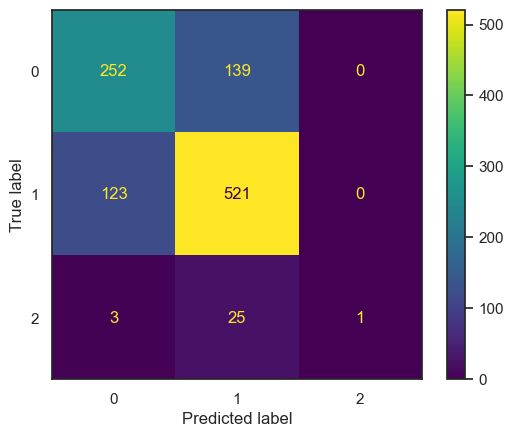

In [142]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

sns.set(style="white")

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [143]:
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7274436090225563
Precision: 0.8090835360908354
Recall: 0.4959967495243975


<Axes: >

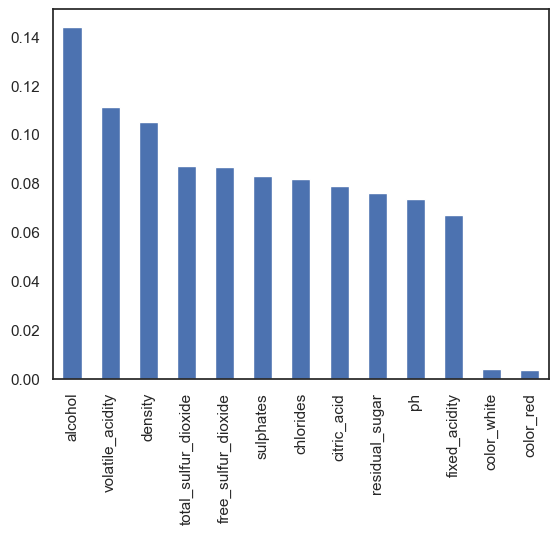

In [144]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()